# Explanation
This code analyses time lapse images of plates with growing colonies and gets their size and mean fluorescence over time together with some valuable characterization of their dynamics. It uses the python module FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size
 - Have _fluopi_ module installed (open Terminal in Mac or command line in Windows and type  `pip install fluopi`; more info [here](https://packaging.python.org/tutorials/installing-packages/) about installing python packages)


## Analysis

### Loading packages
As part of the [FluoPi](https://osf.io/dy6p2/) project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [1]:
# Import the FluoPi module
from fluopi import plotting as flup
from fluopi import analysis as flua
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading Data

In this section you have to include the path of the data to be used. Be careful because it asumes you have the images in a subfolder in the same path as this notebook. If you have the images in another external folder you have to include the full path direction (e.g. _'C/myuser/.../my_images_folder'_)

If you downloaded all the github repository you should have the images in the subfolder _'Images/'_ and then the path should be up and ready.

Also, the example data can be obtained from the **_Files_** section in the [OSF FluoPi proyect](https://osf.io/dy6p2/). There you can download it from the *Google drive/Example_data/Size_and_fluo* folder. Also, there you can found  other image series of your intertest.

After specifying the folder name where the images are stored, we are able to count the files:

In [2]:
fpath = os.path.abspath('Time-lapse')
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

/Users/francisco/Downloads/Biologia sintetica/FluoPi-master/Examples/Time-lapse
/Users/francisco/Downloads/Biologia sintetica/FluoPi-master/Examples/Time-lapse = 95 files


The _fluopi_ module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [3]:
import os
fname = os.path.join(fpath, 'remixNH_%04d.jpg')

Frames = 2
#Frames=12   # use one image every 12 frames, uncomment if you use the original data

DataS={}
DataS['R'],DataS['G'],DataS['B'] = flua.get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be known from the python timelapse hardware control code stored on the folder (named 'interval' in the code).

In [4]:
#define it in hour units
dT=0.5  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


With this, we can construct a **time vector** 'T' for *DataS*

In [5]:
w,h,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames*dT

print(T)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

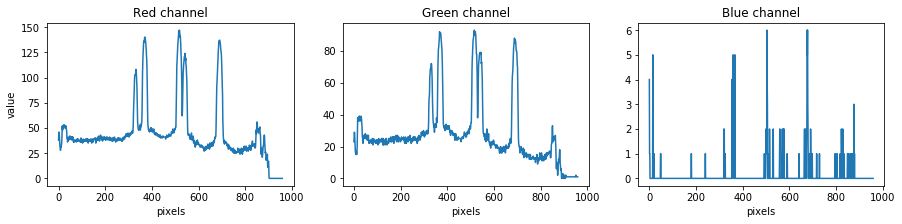

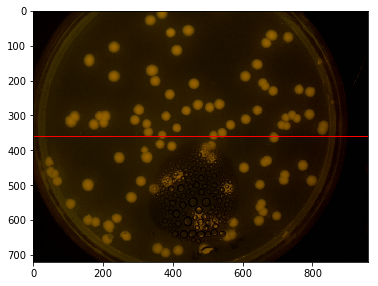

In [6]:
flup.row_transect(DataS, row=int(w/2), x_frames=Frames)

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

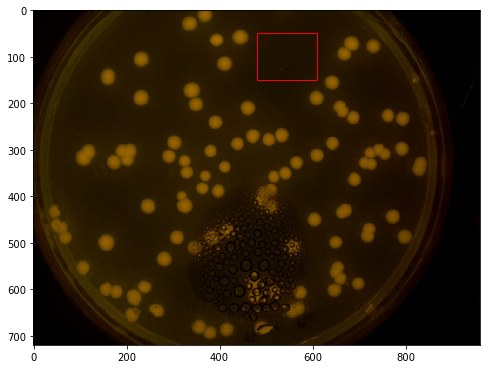

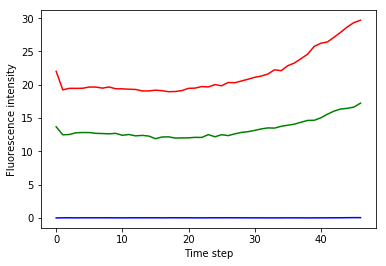

In [7]:
BG = flua.bg_value(50, 150, 480, 610, DataS, imCount)

We can substract this background value from each frame using BG_subst:

In [8]:
DataSB = flua.bg_subst(DataS,BG)

and we can check the effect on the background

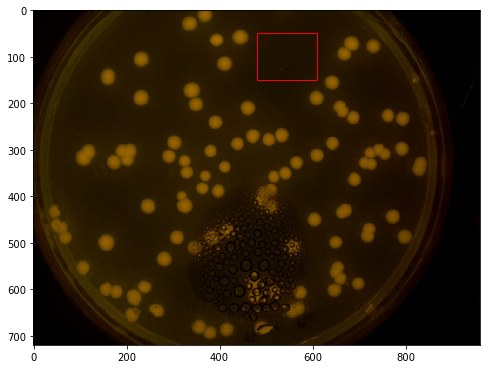

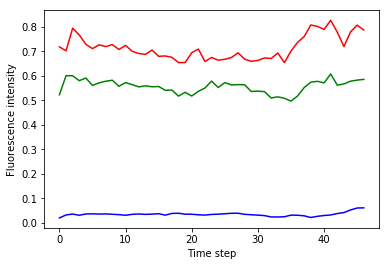

In [9]:
_ = flua.bg_value(50, 150, 480, 610, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

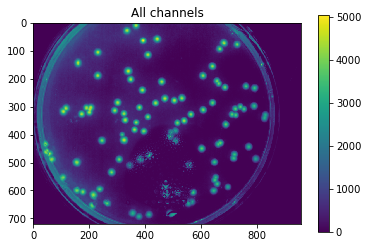

In [10]:
SumData = flua.data_sum_time(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [11]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [12]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]

filtered:


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

Then we apply a the filter to the data (re-run the next line with different sigma values until you agree the smooth):

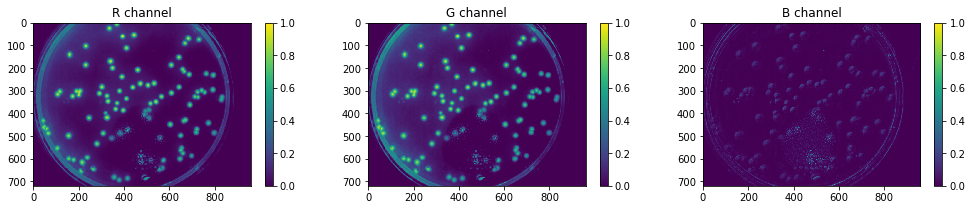

In [13]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.7)

And we can see the plot of the sumarized result

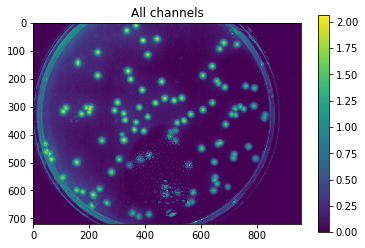

In [14]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the threshold for each dataset manually (based on the previous colormap)

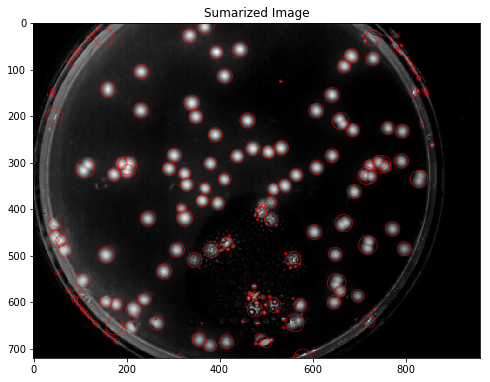

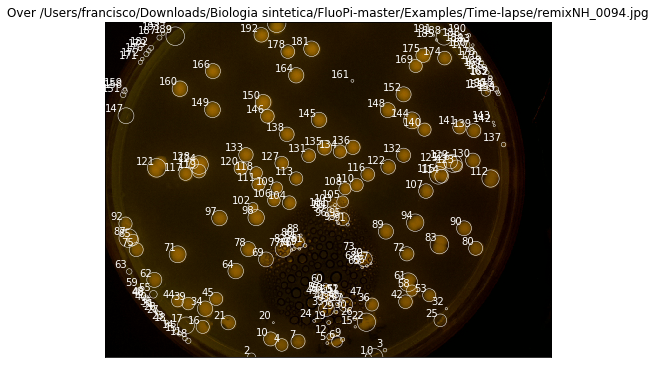

In [15]:
blobD = flua.colony_blobs_id(sDatSall,0.26,fname%(lim),filename='Plots/Size_and_fluo/DetectedBlobs')

With the previous procedure we have identified where each colony is placed

To perform further analysis on each colony it is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [16]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 700 719 560 599
ROI x1 x2 y1 y2
1 712 719 559 574
ROI x1 x2 y1 y2
2 710 719 306 325
ROI x1 x2 y1 y2
3 700 709 598 607
ROI x1 x2 y1 y2
4 680 707 367 394
ROI x1 x2 y1 y2
5 686 693 475 482
ROI x1 x2 y1 y2
6 674 699 487 512
ROI x1 x2 y1 y2
7 670 701 400 431
ROI x1 x2 y1 y2
8 678 691 173 186
ROI x1 x2 y1 y2
9 676 687 506 517
ROI x1 x2 y1 y2
10 665 696 341 372
ROI x1 x2 y1 y2
11 674 685 167 178
ROI x1 x2 y1 y2
12 668 683 477 492
ROI x1 x2 y1 y2
13 664 675 155 166
ROI x1 x2 y1 y2
14 659 670 149 160
ROI x1 x2 y1 y2
15 651 658 535 542
ROI x1 x2 y1 y2
16 640 669 196 225
ROI x1 x2 y1 y2
17 633 670 156 193
ROI x1 x2 y1 y2
18 644 655 132 143
ROI x1 x2 y1 y2
19 641 650 477 486
ROI x1 x2 y1 y2
20 643 648 360 365
ROI x1 x2 y1 y2
21 630 661 250 281
ROI x1 x2 y1 y2
22 624 665 542 583
ROI x1 x2 y1 y2
23 639 650 127 138
ROI x1 x2 y1 y2
24 638 645 447 454
ROI x1 x2 y1 y2
25 626 655 707 736
ROI x1 x2 y1 y2
26 632 641 533 542
ROI x1 x2 y1 y2
27 626 637 115 126
ROI x1 x2 y1 y2
28 619 630 108

ROI x1 x2 y1 y2
76 484 491 403 410
ROI x1 x2 y1 y2
77 470 505 366 401
ROI x1 x2 y1 y2
78 471 504 292 325
ROI x1 x2 y1 y2
79 483 490 415 422
ROI x1 x2 y1 y2
80 470 501 782 813
ROI x1 x2 y1 y2
81 475 484 426 435
ROI x1 x2 y1 y2
82 476 481 391 396
ROI x1 x2 y1 y2
83 457 498 699 740
ROI x1 x2 y1 y2
84 460 487 403 430
ROI x1 x2 y1 y2
85 455 480 48 73
ROI x1 x2 y1 y2
86 462 471 404 413
ROI x1 x2 y1 y2
87 443 484 30 71
ROI x1 x2 y1 y2
88 454 461 418 425
ROI x1 x2 y1 y2
89 433 466 588 621
ROI x1 x2 y1 y2
90 426 459 756 789
ROI x1 x2 y1 y2
91 431 438 519 526
ROI x1 x2 y1 y2
92 418 447 30 59
ROI x1 x2 y1 y2
93 428 435 498 505
ROI x1 x2 y1 y2
94 411 450 648 687
ROI x1 x2 y1 y2
95 408 437 497 526
ROI x1 x2 y1 y2
96 419 426 479 486
ROI x1 x2 y1 y2
97 403 438 229 264
ROI x1 x2 y1 y2
98 401 438 307 344
ROI x1 x2 y1 y2
99 409 416 474 481
ROI x1 x2 y1 y2
100 394 419 477 502
ROI x1 x2 y1 y2
101 397 408 478 489
ROI x1 x2 y1 y2
102 386 409 307 330
ROI x1 x2 y1 y2
103 389 396 492 499
ROI x1 x2 y1 y2
104 37

ROI x1 x2 y1 y2
131 271 302 423 454
ROI x1 x2 y1 y2
132 270 301 627 658
ROI x1 x2 y1 y2
133 269 300 288 319
ROI x1 x2 y1 y2
134 263 292 491 520
ROI x1 x2 y1 y2
135 253 286 456 489
ROI x1 x2 y1 y2
136 253 284 518 549
ROI x1 x2 y1 y2
137 257 268 852 863
ROI x1 x2 y1 y2
138 224 257 375 408
ROI x1 x2 y1 y2
139 217 248 778 809
ROI x1 x2 y1 y2
140 216 245 673 702
ROI x1 x2 y1 y2
141 211 240 748 777
ROI x1 x2 y1 y2
142 219 224 835 840
ROI x1 x2 y1 y2
143 211 218 832 839
ROI x1 x2 y1 y2
144 192 229 642 679
ROI x1 x2 y1 y2
145 192 227 443 478
ROI x1 x2 y1 y2
146 186 217 334 365
ROI x1 x2 y1 y2
147 183 218 28 63
ROI x1 x2 y1 y2
148 172 205 592 625
ROI x1 x2 y1 y2
149 170 205 214 249
ROI x1 x2 y1 y2
150 154 189 323 358
ROI x1 x2 y1 y2
151 149 162 33 46
ROI x1 x2 y1 y2
152 138 171 626 659
ROI x1 x2 y1 y2
153 149 158 842 851
ROI x1 x2 y1 y2
154 145 154 840 849
ROI x1 x2 y1 y2
155 138 159 809 830
ROI x1 x2 y1 y2
156 141 154 36 49
ROI x1 x2 y1 y2
157 143 150 823 830
ROI x1 x2 y1 y2
158 137 150 835 84

we can ilustrate the data with the first blob (colony)

In [17]:
# show the first column of the first ROI
print(Rois['R'][0][:,1,1])
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.88703411e-07   1.62500314e-04   3.53742890e-03   2.09184988e-02
   2.74259134e-01   1.41257950e+00   2.96116306e+00]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]


The ROI let us to track every colony in a seperatelly way. The module includes a package to save an image of a selected ROI at selected times. Then is possible make timelapse grow of an indivial colony.

In [ ]:
#Orange example
idx=148
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[20,40,60,80,94]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

In [ ]:
#Red example
idx=24
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[70,90,110,130,150]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

In [ ]:
#Green example
idx=33
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[70,90,110,130,150]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
With the data obtained so far we can plot the fluorescence dynamics of colonies. We can choose some representative colonies and use the FluoPi `rois_plt_fluo_dynam()` function to perform this task:

Each line correspond to a different ROI


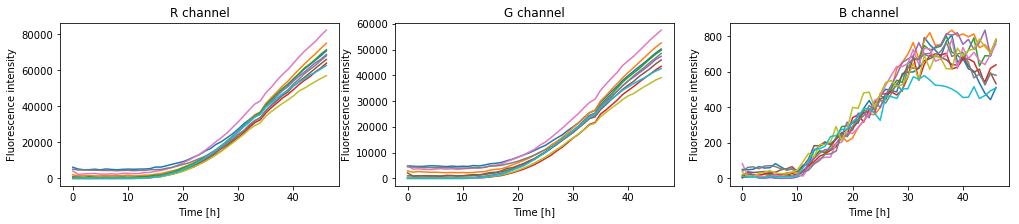

In [18]:
#define the selected colonies
Cols=[160,149,164,152,145,64,71,166,122,136]

#use the function to plot
#flup.rois_plt_fluo_dynam(RoisC,T,Cols)
flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and a final size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [19]:
ACRois=flua.channels_sum(RoisC,Cols) #circular ROIS

In [20]:
ACRoisS=flua.channels_sum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [21]:
import time
start = time.time()
R_frame=flua.frame_colony_radius(ACRoisS,Cols,0.37)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

39.466554164886475 seg


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

Each line correspond to one colony


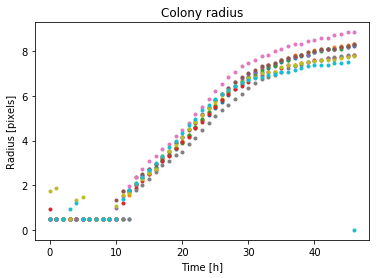

In [22]:
flup.plot_radius(R_frame, Cols, T)
print('Each line correspond to one colony')

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


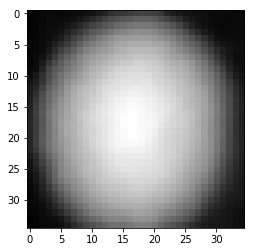

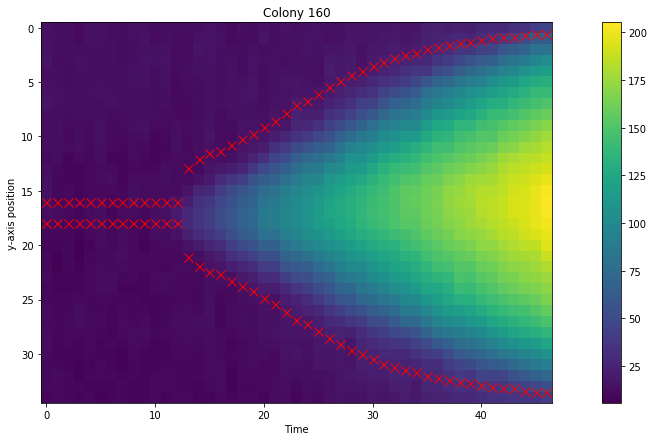

In [23]:
IDCol=Cols[0]
print()
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol]flua.)
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], filename='Plots/Size_and_fluo/Kymograph_'+str(IDCol))


##### Getting the colony area over time $A(t)$
with the radius value we are able to get the colony area over time by taking it as a perfect circle: $$A(t) = \pi \cdot r^{2}$$

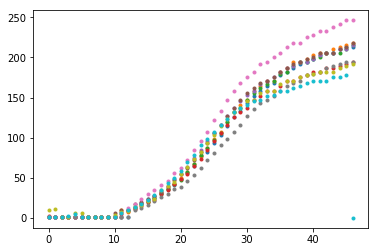

In [24]:
A=flua.area(R_frame,Cols,T)

To improve determination of radius we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
A(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

where $a$ is the maximum area of the colony ($a = A_{max}$) and  $b$ is the time where the colony reach half of his maximum growth ($b = t_d$)

You can se the effect of the parameters evaluating the function F_logistic:

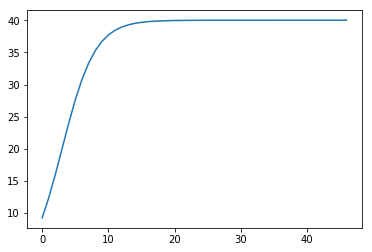

In [25]:
Sigmoid=flua.f_sigma(T, 40, -3, 0.4)
plt.plot(T,Sigmoid)

With the function `function_fit` you can fit a mathematical model (*F_sigma* by default) to one seleceted colony:

[  2.12806560e+02  -2.63645182e+01   1.96041907e-01]


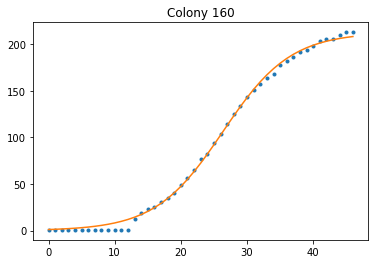

In [26]:
idx=Cols[0:1] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=2
end=-1
SingleF=flua.function_fit(T,A,init,end,idx)

or you can perform the fit to a dictionary of selected colonies with the same function:

[  2.12806560e+02  -2.63645182e+01   1.96041907e-01]


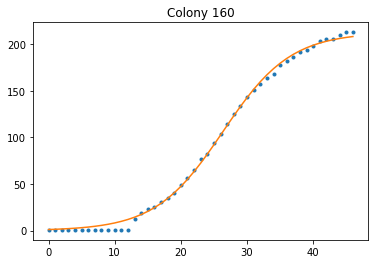

[  2.14597875e+02  -2.60015313e+01   2.01736582e-01]


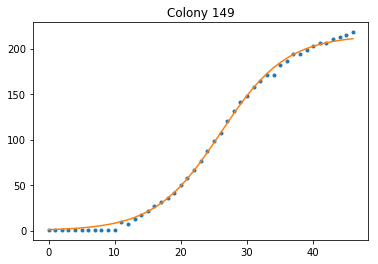

[  2.09061985e+02  -2.58086328e+01   2.06516924e-01]


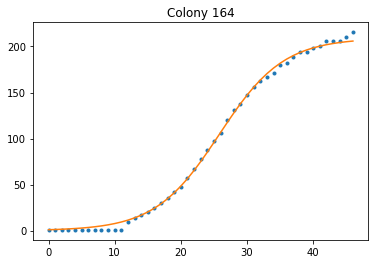

[ 188.39935513  -25.07588707    0.21396375]


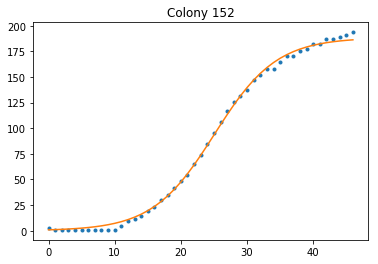

[  2.08396572e+02  -2.50306278e+01   2.07065983e-01]


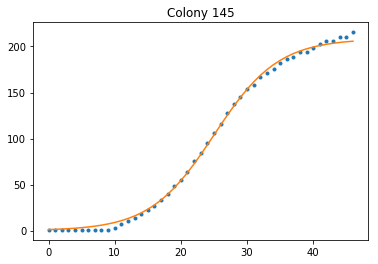

[  2.10255925e+02  -2.51233403e+01   2.06777012e-01]


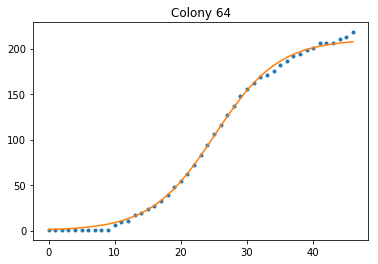

[  2.40018644e+02  -2.50917267e+01   2.04012249e-01]


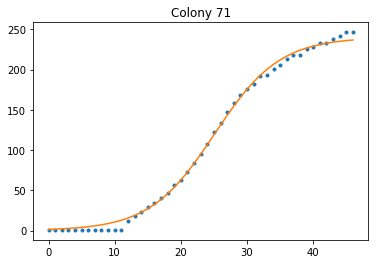

[ 194.15333736  -26.91085439    0.1979766 ]


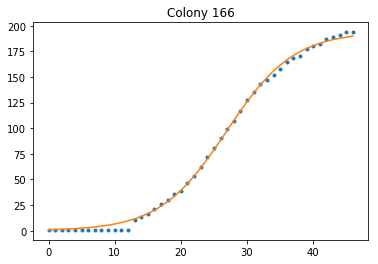

[ 184.14392604  -24.01890443    0.22035394]


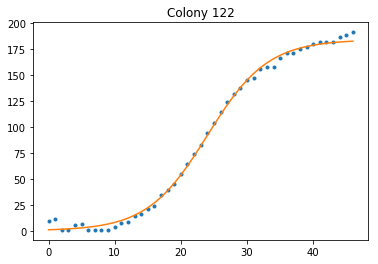

[ 171.38203436  -22.92535734    0.23099362]


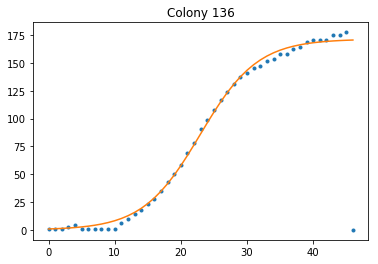

In [27]:
init=2
end=-1
A_fitS=flua.function_fit(T,A,init,end,Cols)

We can put alltogheter on one plot:

In [28]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(Cols))) #Paired o jet #https://matplotlib.org/users/colormaps.html


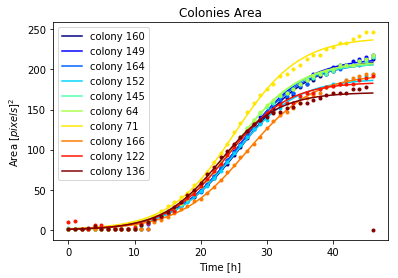

In [29]:
for i, c in zip(Cols, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitS[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)

With the area function we are able to back-compute the radius: $$ r (t) = \sqrt{\frac{A(t)}{\pi}} $$

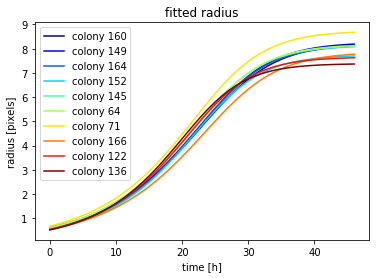

In [30]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols, colors):
    r_fit[i]=(A_fitS[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

We can plot it and the blob radius together:

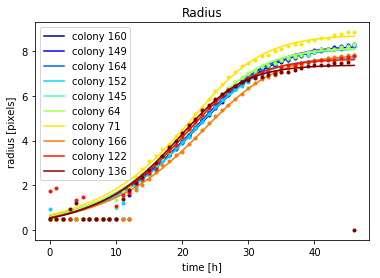

In [31]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

Now we can check the radius estimation again:

/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


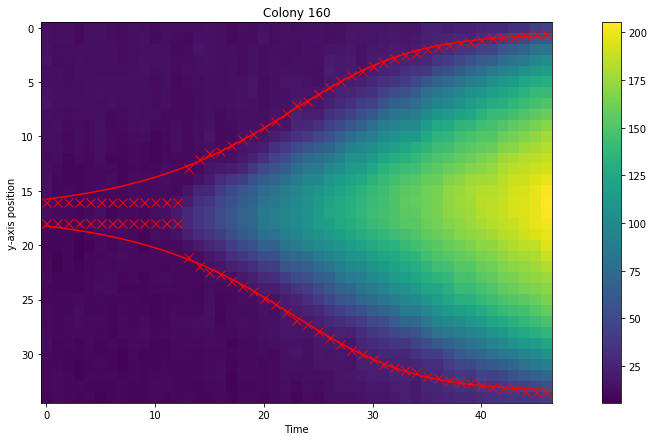

In [32]:
IDCol=int(Cols[0])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol],filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

In [33]:
IDCol=Cols[0]
fname=('ROIs/sumCol'+str(IDCol)+'_ROI_step%d.pdf')
Times=[70,90,110,130,150]
flup.tl_roi(Rois,IDCol,Times,fname,radius=r_fit[IDCol], chan_sum=False, gridsize=[2,3]) 


IndexError: index 70 is out of bounds for axis 2 with size 47

colony grows stimation seems to get more cotinuous and improve greatly at the beginning.

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive (see [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf)) the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$


To be able to estimate the value of this parameter we have to compute the values of each element in his representative equation.

To get an acurate analysis of the gener expression dynamics of the colonies, the module include a function to compute the average fluorescent value inside the limits of the colony (defined by the radius fitting) on each time. This average value correspond to $I/A$ (see the [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf))

In [33]:
MeanInt=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols)

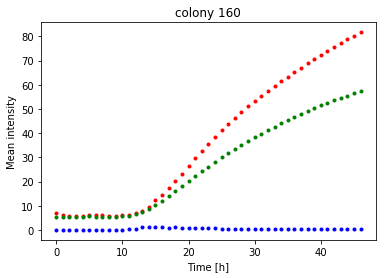

In [34]:
idx=Cols[0]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

by sum the three channels we can get the total intensity per area $(I/A)_{total}$

In [35]:
#let's sum the three channels
MeanInt3C={}
for i in Cols:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


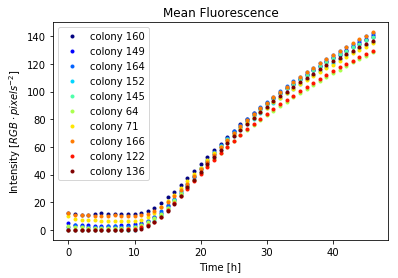

In [36]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True)

print('this plot contain the sum of the mean of the three channels over time for each colony')

With that is possible to compute the derivative of this value: $ d(I/A)/dt $

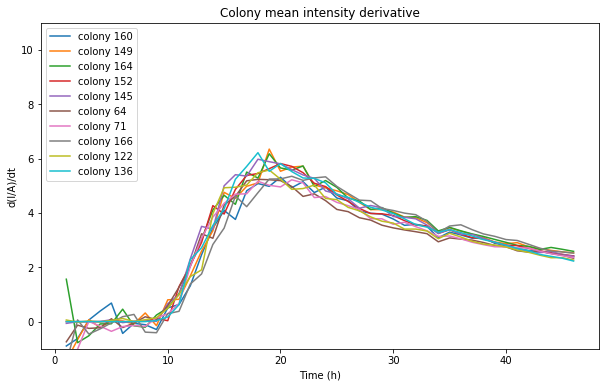

In [37]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in Cols:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,11])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

Finally, we should compute the $\mu(t)=(1/A)dA/dt$
, which under the sigmoideal growth moldel it's equal to: $$\mu = \frac{d}{e^{d \cdot (t+b)}+1} $$

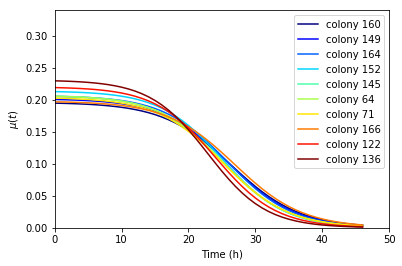

In [38]:
Mu_val={}
for i, c in zip(Cols, colors):
    Mu_val[i]=flua.f_mu(T,A_fitS[i][1][1],A_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    plt.ylim([0,0.34])
    plt.legend(loc='upper right')
plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True)


## Data smoothing

To perform an accurated estimation it's good to apply data smoothing.

In [39]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

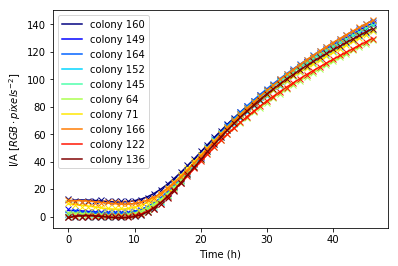

In [40]:
IA_smooth={}

for i, c in zip(Cols, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True)

From this smooth values of _IA_ we can compute his derivative:

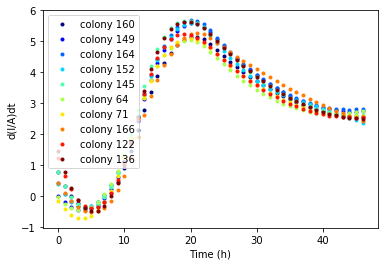

In [41]:
dIAdt={}
for i, c in zip(Cols, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True)

Or we can make the smooth of the previuos *dIAdt_dis* computed values:

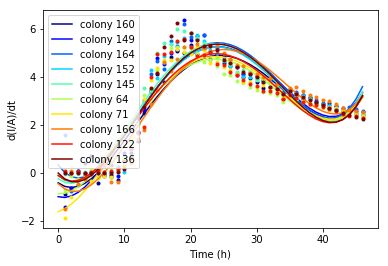

In [42]:
dIAdt_smooth={}

for i, c in zip(Cols, colors):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True)
    

Finally, the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$

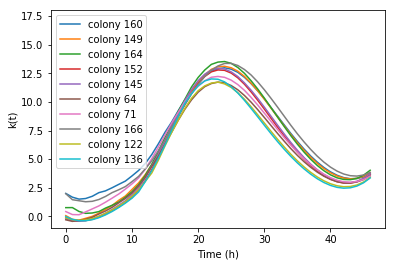

In [43]:
Kf={}
for i, c in zip(Cols, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,18])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)

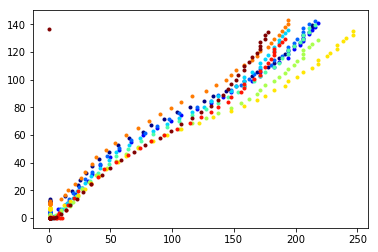

In [45]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(A[i],MeanInt3C[i],'.',color=c,label='colony '+str(i))

In [ ]:
Aca empieza experimento de 30 ºC

In [45]:
fpath = os.path.abspath('Time-lapse30')
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

/Users/francisco/Downloads/Biologia sintetica/FluoPi-master/Examples/Time-lapse30
/Users/francisco/Downloads/Biologia sintetica/FluoPi-master/Examples/Time-lapse30 = 65 files


In [46]:
import os
fname = os.path.join(fpath, 'remixNH_%04d.jpg')

Frames = 2
#Frames=12   # use one image every 12 frames, uncomment if you use the original data

DataS={}
DataS['R'],DataS['G'],DataS['B'] = flua.get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

In [47]:
#define it in hour units
dT=0.5  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


In [48]:
w,h,st=DataS['R'].shape
T2=np.zeros((st))
for i in range(0,st):
    T2[i]=(i)*Frames*dT

print(T2)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.]


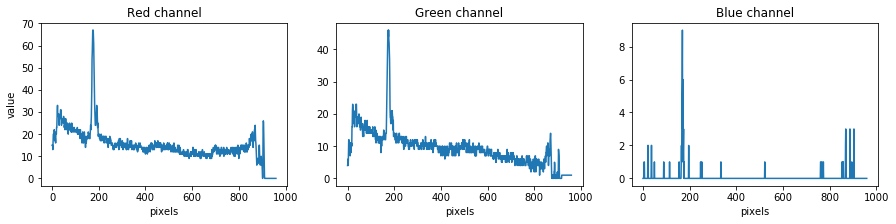

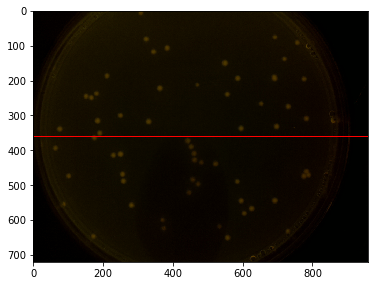

In [49]:
flup.row_transect(DataS, row=int(w/2), x_frames=Frames)

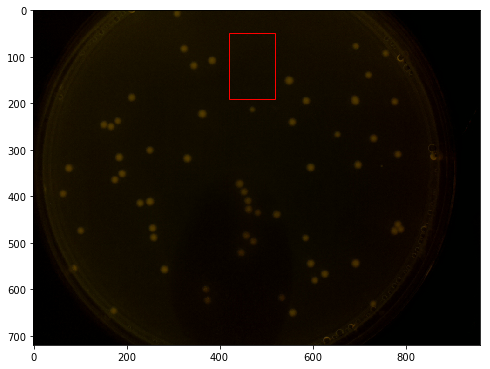

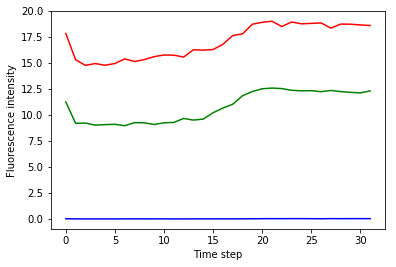

In [50]:
BG = flua.bg_value(50, 190, 420, 520, DataS, imCount)

In [51]:
DataSB = flua.bg_subst(DataS,BG)

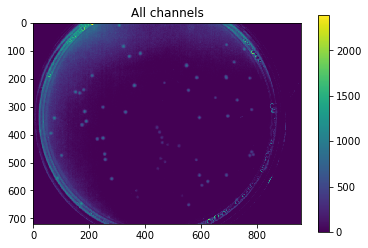

In [52]:
SumData = flua.data_sum_time(DataSB)

In [53]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]

filtered:


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

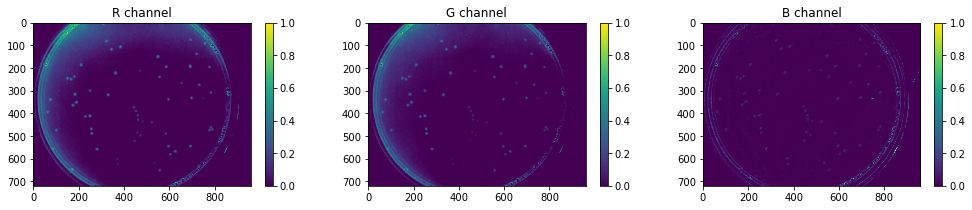

In [54]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.7)

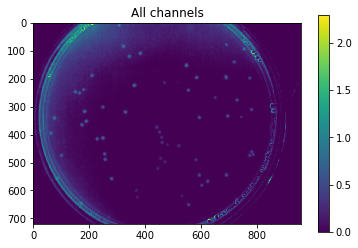

In [55]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

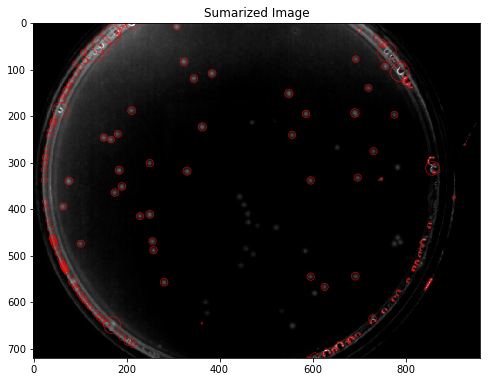

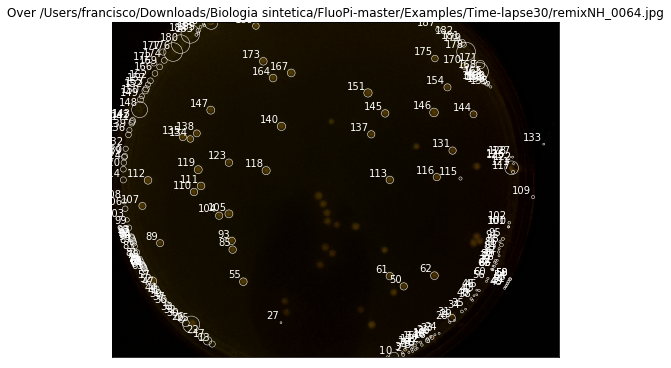

In [56]:
blobD = flua.colony_blobs_id(sDatSall,0.26,fname%(lim),filename='Plots/Size_and_fluo/DetectedBlobs')

In [57]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 709 719 595 616
ROI x1 x2 y1 y2
1 716 719 588 595
ROI x1 x2 y1 y2
2 711 718 622 629
ROI x1 x2 y1 y2
3 708 713 621 626
ROI x1 x2 y1 y2
4 707 712 635 640
ROI x1 x2 y1 y2
5 705 710 643 648
ROI x1 x2 y1 y2
6 701 706 649 654
ROI x1 x2 y1 y2
7 700 707 626 633
ROI x1 x2 y1 y2
8 699 706 640 647
ROI x1 x2 y1 y2
9 698 703 653 658
ROI x1 x2 y1 y2
10 697 702 643 648
ROI x1 x2 y1 y2
11 691 698 647 654
ROI x1 x2 y1 y2
12 690 697 662 669
ROI x1 x2 y1 y2
13 684 699 207 222
ROI x1 x2 y1 y2
14 685 690 660 665
ROI x1 x2 y1 y2
15 685 690 653 658
ROI x1 x2 y1 y2
16 682 689 676 683
ROI x1 x2 y1 y2
17 675 694 195 214
ROI x1 x2 y1 y2
18 678 689 672 683
ROI x1 x2 y1 y2
19 677 684 674 681
ROI x1 x2 y1 y2
20 673 682 683 692
ROI x1 x2 y1 y2
21 672 679 681 688
ROI x1 x2 y1 y2
22 668 683 184 199
ROI x1 x2 y1 y2
23 669 674 691 696
ROI x1 x2 y1 y2
24 666 671 700 705
ROI x1 x2 y1 y2
25 631 668 151 188
ROI x1 x2 y1 y2
26 638 655 149 166
ROI x1 x2 y1 y2
27 643 648 360 365
ROI x1 x2 y1 y2
28 641 648 722

ROI x1 x2 y1 y2
98 454 467 34 47
ROI x1 x2 y1 y2
99 435 448 29 42
ROI x1 x2 y1 y2
100 437 442 850 855
ROI x1 x2 y1 y2
101 436 443 848 855
ROI x1 x2 y1 y2
102 427 434 850 857
ROI x1 x2 y1 y2
103 419 430 26 37
ROI x1 x2 y1 y2
104 407 424 221 238
ROI x1 x2 y1 y2
105 402 421 241 260
ROI x1 x2 y1 y2
106 394 407 21 34
ROI x1 x2 y1 y2
107 386 403 56 73
ROI x1 x2 y1 y2
108 378 391 19 32
ROI x1 x2 y1 y2
109 372 379 901 908
ROI x1 x2 y1 y2
110 356 373 167 184
ROI x1 x2 y1 y2
111 343 360 182 199
ROI x1 x2 y1 y2
112 331 348 68 85
ROI x1 x2 y1 y2
113 330 347 588 605
ROI x1 x2 y1 y2
114 331 346 16 31
ROI x1 x2 y1 y2
115 332 339 745 752
ROI x1 x2 y1 y2
116 324 341 689 706
ROI x1 x2 y1 y2
117 318 325 858 865
ROI x1 x2 y1 y2
118 309 328 321 340
ROI x1 x2 y1 y2
119 307 326 175 194
ROI x1 x2 y1 y2
120 309 322 17 30
ROI x1 x2 y1 y2
121 297 328 843 874
ROI x1 x2 y1 y2
122 301 306 860 865
ROI x1 x2 y1 y2
123 293 310 242 259
ROI x1 x2 y1 y2
124 295 308 18 31
ROI x1 x2 y1 y2
125 297 302 847 852
ROI x1 x2 y1 y

ROI x1 x2 y1 y2
185 19 26 181 188
ROI x1 x2 y1 y2
186 12 23 179 190
ROI x1 x2 y1 y2
187 10 21 695 706
ROI x1 x2 y1 y2
188 6 13 186 193
ROI x1 x2 y1 y2
189 0 15 301 316
ROI x1 x2 y1 y2
190 3 10 194 201
ROI x1 x2 y1 y2
191 0 7 192 199
ROI x1 x2 y1 y2
192 0 15 198 227


Each line correspond to a different ROI


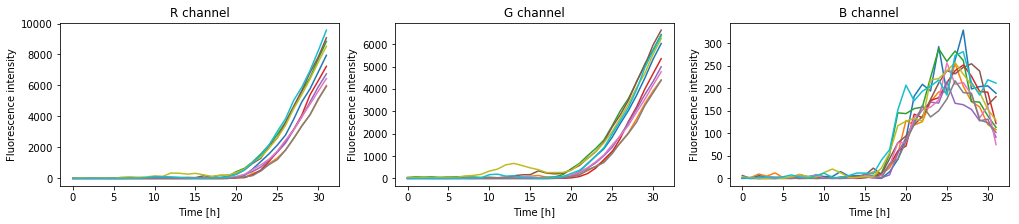

In [58]:
#define the selected colonies
Cols2=[118,123,140,55,85,151,145,137,119,146]

#use the function to plot
#flup.rois_plt_fluo_dynam(RoisC,T,Cols)
flup.rois_plt_fluo_dynam(RoisC,T2,Cols2,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

In [59]:
ACRois=flua.channels_sum(RoisC,Cols2) #circular ROIS

In [60]:
ACRoisS=flua.channels_sum(Rois,Cols2) #square ROIS

In [61]:
import time
start = time.time()
R_frame2=flua.frame_colony_radius(ACRoisS,Cols2,0.37)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/analysis.py:485: RuntimeWarning: invalid value encountered in true_divide
  nt_roi = (troi-troi.min())/(troi.max()-troi.min())
/Users/francisco/anaconda/lib/python3.6/site-packages/skimage/feature/peak.py:185: RuntimeWarning: invalid value encountered in greater
  mask &= image > max(thresholds)


18.14641571044922 seg


Each line correspond to one colony


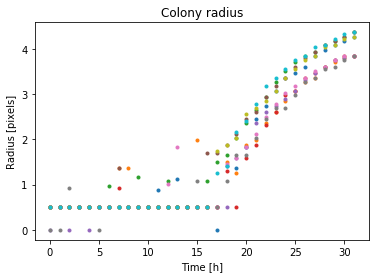

In [62]:
flup.plot_radius(R_frame2, Cols2, T2)
print('Each line correspond to one colony')

/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


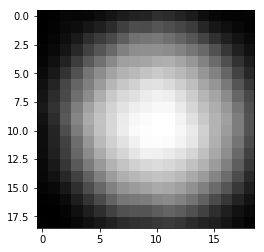

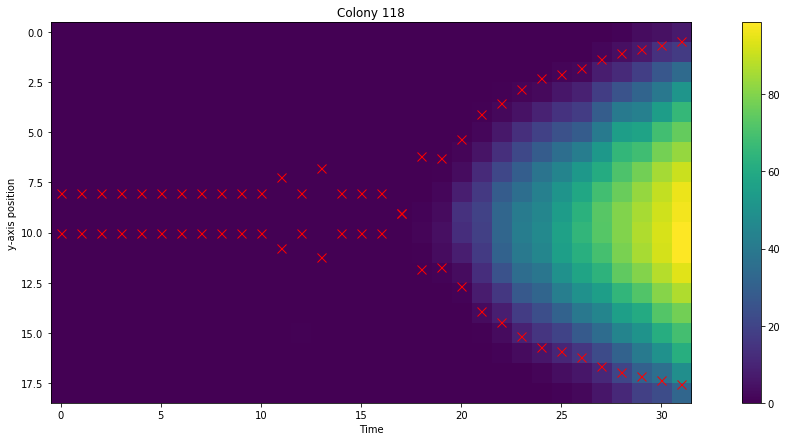

In [63]:
IDCol=Cols2[0]
print()
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol]flua.)
flup.check_radius(ACRoisS, IDCol, T2, r_dots=R_frame2[IDCol], filename='Plots/Size_and_fluo/Kymograph_'+str(IDCol))


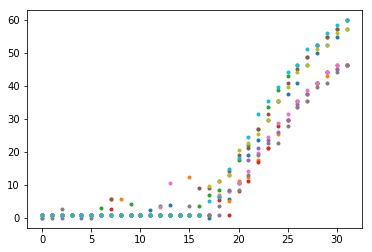

In [64]:
A2=flua.area(R_frame2,Cols2,T2)

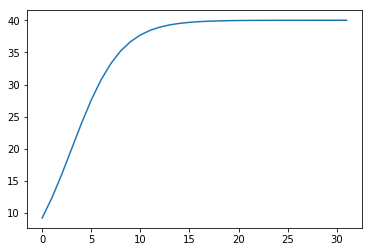

In [65]:
Sigmoid=flua.f_sigma(T2, 40, -3, 0.4)
plt.plot(T2,Sigmoid)

[ 55.03538375 -22.90094661   0.44504753]


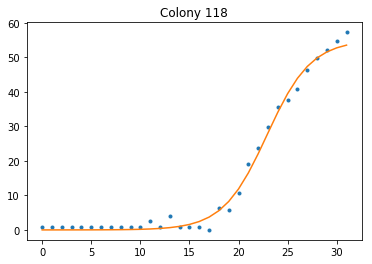

In [66]:
idx=Cols2[0:1] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=2
end=-1
SingleF=flua.function_fit(T2,A2,init,end,idx)

[ 55.03538375 -22.90094661   0.44504753]


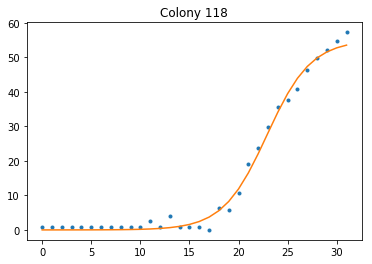

[ 53.03859402 -24.39542414   0.31742656]


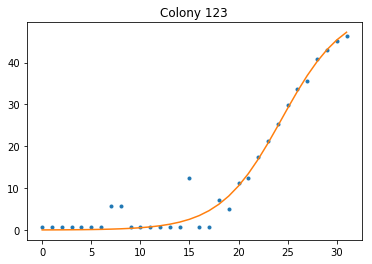

[ 58.92528319 -22.40166581   0.38279902]


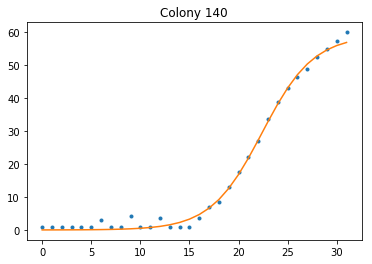

[ 47.06974839 -23.52953636   0.46237554]


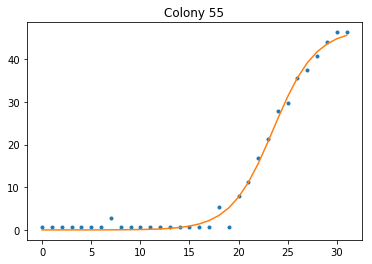

[ 46.70680212 -23.1027503    0.40476512]


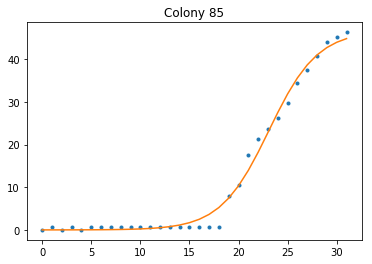

[ 62.97786121 -23.00579304   0.31633323]


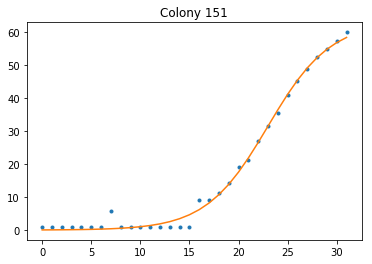

[ 49.02451457 -23.27112524   0.37361224]


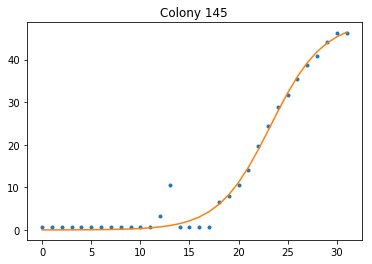

[ 47.11466703 -23.67921703   0.37200843]


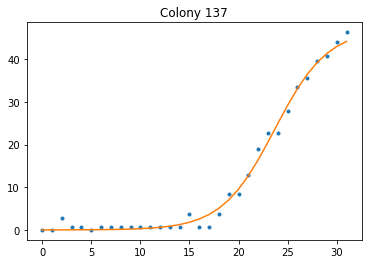

[ 58.83284049 -22.6956809    0.34121641]


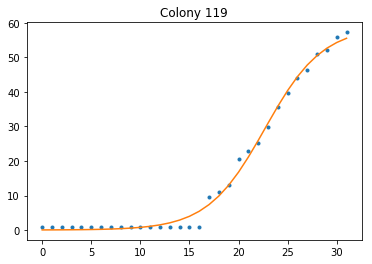

[ 57.31613232 -21.90968517   0.43488746]


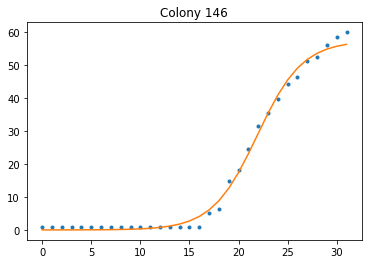

In [67]:
init=2
end=-1
A_fitS2=flua.function_fit(T2,A2,init,end,Cols2)

In [68]:
#set the color vector to have concordance between dots and fitted curves
colors2 = plt.cm.jet(np.linspace(0, 1, len(Cols2))) #Paired o jet #https://matplotlib.org/users/colormaps.html


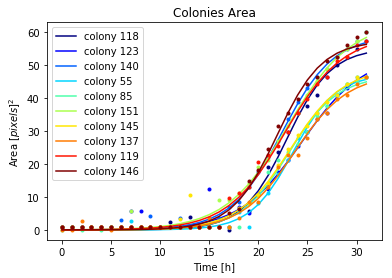

In [69]:
for i, c in zip(Cols2, colors2):
    plt.plot(T2,A2[i],'.',color=c)
    plt.plot(T2,A_fitS2[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)

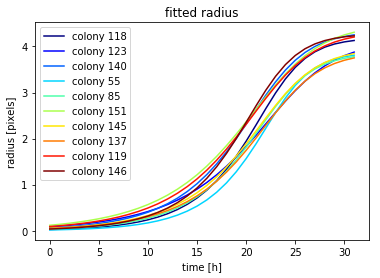

In [70]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols2, colors2):
    r_fit[i]=(A_fitS2[i][0]/pi)**(0.5)
    
    plt.plot(T2,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

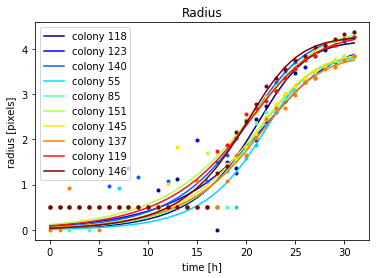

In [71]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols2, colors2):
    plt.plot(T2,R_frame2[i],'.',color=c)
    plt.plot(T2,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
/Users/francisco/anaconda/lib/python3.6/site-packages/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


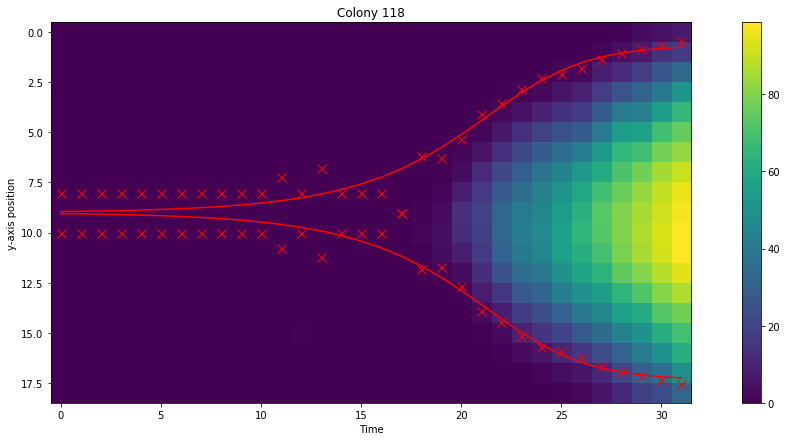

In [72]:
IDCol=int(Cols2[0])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T2,r_fit=r_fit[IDCol],r_dots=R_frame2[IDCol],filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

In [73]:
MeanInt2=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols2)

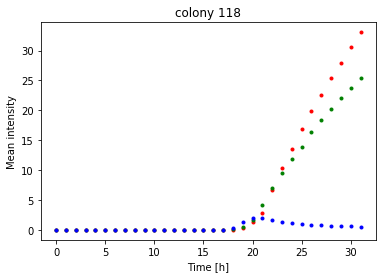

In [74]:
idx=Cols2[0]
plt.plot(T2,MeanInt2['R'][idx],'.',color='r')
plt.plot(T2,MeanInt2['G'][idx],'.',color='g')
plt.plot(T2,MeanInt2['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

In [75]:
#let's sum the three channels
MeanInt3C2={}
for i in Cols2:
    Vaux=np.zeros((MeanInt2['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt2[c][i]
    
    MeanInt3C2[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


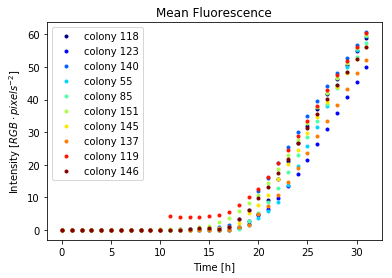

In [76]:
plt.figure()
for i, c in zip(Cols2, colors2):
    plt.plot(T2,MeanInt3C2[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True)

print('this plot contain the sum of the mean of the three channels over time for each colony')

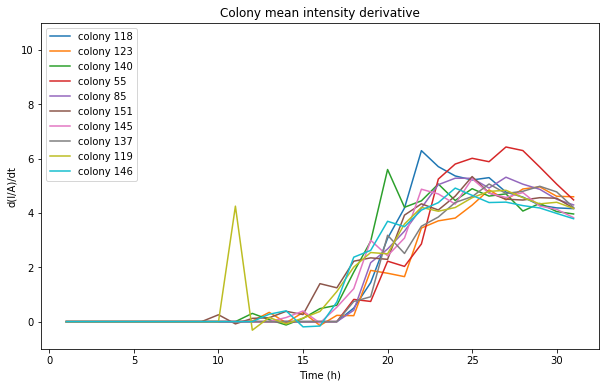

In [77]:
dIAdt_dis2={}
plt.figure(figsize=(10,6))
for i in Cols2:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C2 = np.diff(MeanInt3C2[i])
    delta_T2=np.diff(T2)
    dIAdt_dis2[i] = delta_MeanInt3C2/delta_T2
    plt.plot(T2[1:],dIAdt_dis2[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,11])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

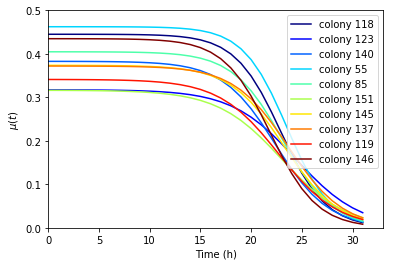

In [78]:
Mu_val2={}
for i, c in zip(Cols2, colors2):
    Mu_val2[i]=flua.f_mu(T2,A_fitS2[i][1][1],A_fitS2[i][1][2])
    plt.plot(T2,Mu_val2[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,33])
    plt.ylim([0,0.5])
    plt.legend(loc='upper right')
plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True)


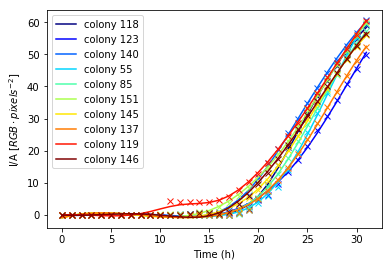

In [79]:
IA_smooth2={}

for i, c in zip(Cols2, colors2):
    IA_smooth2[i] = UnivariateSpline(T2,MeanInt3C2[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth2[i].set_smoothing_factor(10)
    plt.plot(T2,IA_smooth2[i](T2[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T2,MeanInt3C2[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True)

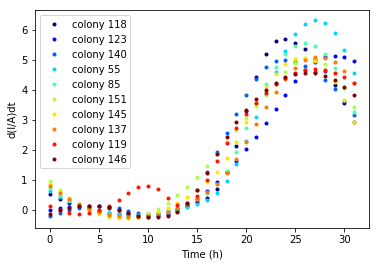

In [80]:
dIAdt2={}
for i, c in zip(Cols2, colors2):
    dIAdt2[i]=IA_smooth2[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T2,dIAdt2[i](T2),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True)

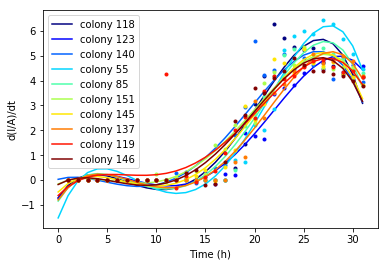

In [81]:
dIAdt_smooth2={}

for i, c in zip(Cols2, colors2):
    dIAdt_smooth2[i] = UnivariateSpline(T2[1:],dIAdt_dis2[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T2[:],dIAdt_smooth2[i](T2[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T2[1:],dIAdt_dis2[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True)
    

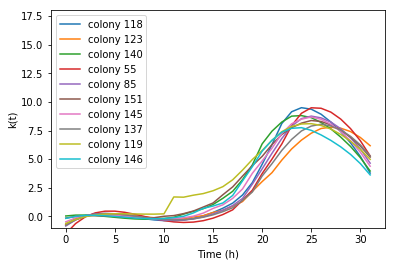

In [82]:
Kf2={}
for i, c in zip(Cols2, colors2):
    Kf2[i]=dIAdt_smooth2[i](T2[:])+Mu_val2[i]*MeanInt3C2[i]
    plt.plot(T2[:],Kf2[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,18])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)

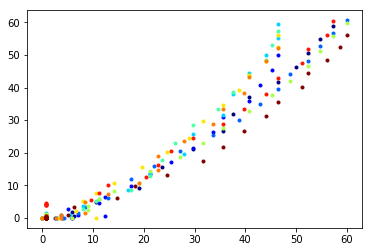

In [100]:
plt.figure()
for i, c in zip(Cols2, colors2):
    plt.plot(A2[i],MeanInt3C2[i],'.',color=c,label='colony '+str(i))

In [115]:
print(MeanInt3C2)

{118: array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.38545664e-03,
         2.69272832e-03,   2.00829531e-03,   1.00414766e-03,
         4.99815744e-01,   1.93450452e+00,   4.99854078e+00,
         9.17935144e+00,   1.54696349e+01,   2.11718975e+01,
         2.65312695e+01,   3.17436517e+01,   3.70407719e+01,
         4.18073862e+01,   4.63890697e+01,   5.06731657e+01,
         5.48571887e+01,   5.90139157e+01]), 123: array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.86820103e-02,   3.59652754e-01,   3.19400170e-01,
         6.56211753e-01,   5.

In [114]:
print(A2)

{118: array([  0.78539816,   0.78539816,   0.78539816,   0.78539816,
         0.78539816,   0.78539816,   0.78539816,   0.78539816,
         0.78539816,   0.78539816,   0.78539816,   2.44341908,
         0.78539816,   3.94505849,   0.78539816,   0.78539816,
         0.78539816,   0.        ,   6.21956173,   5.80467968,
        10.59786743,  18.96974261,  23.64988348,  29.76157468,
        35.55861873,  37.60552093,  40.78326875,  46.36590055,
        49.88731089,  52.30651414,  54.78299448,  57.31675191]), 123: array([  0.78539816,   0.78539816,   0.78539816,   0.78539816,
         0.78539816,   0.78539816,   0.78539816,   5.80467968,
         5.80467968,   0.78539816,   0.78539816,   0.78539816,
         0.78539816,   0.78539816,   0.78539816,  12.31504955,
         0.78539816,   0.78539816,   7.09228365,   5.01787339,
        11.1559422 ,  12.31504955,  17.52424982,  21.24537632,
        25.3244846 ,  29.76157468,  33.56899363,  35.55861873,
        40.78326875,  42.97336365,  45.220

In [116]:
print(Mu_val2)

{118: array([ 0.44503086,  0.44502151,  0.44500693,  0.44498417,  0.44494865,
        0.44489325,  0.4448068 ,  0.44467197,  0.44446173,  0.44413402,
        0.44362357,  0.44282933,  0.44159553,  0.43968378,  0.43673322,
        0.43220699,  0.42532797,  0.41501971,  0.39989494,  0.37837579,
        0.34906253,  0.31141303,  0.26654754,  0.21761975,  0.16916181,
        0.12553801,  0.08951389,  0.06182683,  0.0416991 ,  0.02765116,
        0.01812316,  0.0117856 ]), 123: array([ 0.31728903,  0.31723768,  0.31716718,  0.31707039,  0.31693753,
        0.31675523,  0.31650515,  0.3161623 ,  0.31569257,  0.31504962,
        0.31417073,  0.31297146,  0.31133901,  0.30912425,  0.30613296,
        0.30211729,  0.29677011,  0.28972653,  0.28057937,  0.26891737,
        0.25439357,  0.23682466,  0.21630535,  0.19330022,  0.16866092,
        0.14353064,  0.11914588,  0.09660251,  0.0766751 ,  0.05974618,
        0.04584324,  0.03473936]), 140: array([ 0.3827268 ,  0.38269312,  0.38264375,  0.3

In [111]:

plt.plot(np.polyfit(A[160],A[149],A[164],2))

TypeError: only length-1 arrays can be converted to Python scalars

In [118]:
print(R_frame2)

{118: array([ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.88190955,  0.5       ,  1.12060302,  0.5       ,
        0.5       ,  0.5       ,  0.        ,  1.40703518,  1.35929648,
        1.83668342,  2.45728643,  2.74371859,  3.07788945,  3.36432161,
        3.45979899,  3.60301508,  3.84170854,  3.98492462,  4.08040201,
        4.1758794 ,  4.27135678]), 123: array([ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  1.35929648,  1.35929648,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        1.9798995 ,  0.5       ,  0.5       ,  1.50251256,  1.2638191 ,
        1.88442211,  1.9798995 ,  2.36180905,  2.60050251,  2.83919598,
        3.07788945,  3.26884422,  3.36432161,  3.60301508,  3.69849246,
        3.79396985,  3.84170854]), 140: array([ 0.5       ,  0.5       ,  0.5       ,  0.5

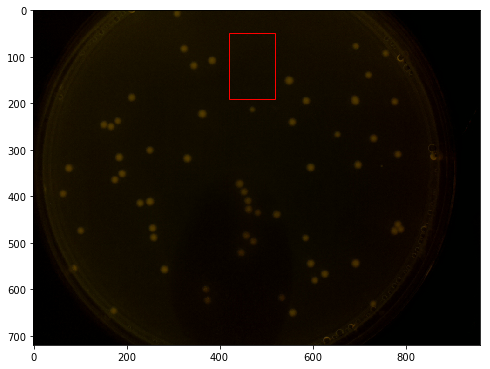

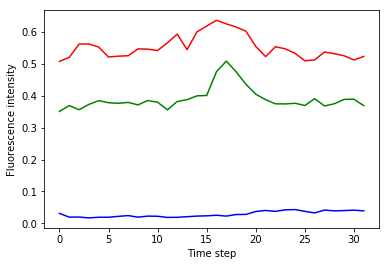

In [12]:
_ = flua.bg_value(50, 190, 420, 520, DataSB, imCount)

In [83]:
print(Kf2)

{118: array([-0.708835  , -0.21908914,  0.07314821,  0.2099809 ,  0.23005489,
        0.16855821,  0.05722101, -0.07568447, -0.20534388, -0.31040079,
       -0.37295665, -0.37857083, -0.3162606 , -0.17850112,  0.04112656,
        0.33733926,  0.71170686,  1.15691623,  1.86322499,  2.95015492,
        4.54912445,  6.26019016,  8.10988028,  9.1392898 ,  9.4953249 ,
        9.36369356,  8.924337  ,  8.24122358,  7.41189344,  6.42536007,
        5.23936399,  3.78127818]), 123: array([ -7.45564030e-01,  -2.94553314e-01,  -2.92278755e-03,
         1.60168511e-01,   2.23231549e-01,   2.12447303e-01,
         1.51666756e-01,   6.24108993e-02,  -3.61292684e-02,
        -1.27092741e-01,  -1.95948504e-01,  -2.30495535e-01,
        -2.15046368e-01,  -4.83318915e-02,   5.65550077e-02,
         3.35127268e-01,   5.27863309e-01,   8.88019227e-01,
         1.29415051e+00,   2.18912122e+00,   3.03942771e+00,
         3.81701320e+00,   4.91453898e+00,   5.88818108e+00,
         6.66136219e+00,   7.26541